In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.gaussian_process as gp
from scipy.integrate import solve_ivp
import scipy.linalg as la
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
from sur_data import rw_metropolis_hastings

In [3]:
%matplotlib notebook
plt.style.use('seaborn')

In [26]:
def lotka_volterra(t,y,a,b,c,d):
    dy = np.empty_like(y)
    # switched to match
    dy[0] = d*y[0]*y[1]-c*y[0]
    dy[1] = a*y[1]-b*y[0]*y[1]
    return dy

def solve_lv(T,y0,a,b,c,d):
    sol = solve_ivp(lotka_volterra,(T[0],T[-1]),y0,t_eval=T,args=(a,b,c,d))
    return sol.y

In [27]:
# choose true parameters
y0 = [2,.5]
a = 1
b = 1
c = 1
d = 1

# generate simulated data
T_obs = np.linspace(0,10,10)
y = solve_lv(T_obs,y0,a,b,c,d)

# set random seed
np.random.seed(2021)

# add noise
sigma = 0.02
y_noisy = np.abs(y + sigma*np.random.randn(y.shape[0],y.shape[1]))

In [28]:
kernel1 = gp.kernels.ConstantKernel()*gp.kernels.RBF()+gp.kernels.WhiteKernel(sigma**2,noise_level_bounds="fixed")
kernel2 = gp.kernels.ConstantKernel()*gp.kernels.RBF()+gp.kernels.WhiteKernel(sigma**2,noise_level_bounds="fixed")
y1_gp = gp.GaussianProcessRegressor(kernel1)
y1_gp = y1_gp.fit(T_obs[:,np.newaxis],y_noisy[0].T)
y2_gp = gp.GaussianProcessRegressor(kernel2)
y2_gp = y2_gp.fit(T_obs[:,np.newaxis],y_noisy[1].T)

In [54]:
# define high-res time points for evaluation
T_sur = np.linspace(0,10,201)

# compute mean and covariance of GPs
mean1,cov1_gp = y1_gp.predict(T_sur[:,np.newaxis],return_cov=True)
mean2,cov2_gp = y2_gp.predict(T_sur[:,np.newaxis],return_cov=True)

# symmytrize
cov1_gp = .5*(cov1_gp+cov1_gp.T)
cov2_gp = .5*(cov2_gp+cov2_gp.T)

# extract and invert diagonal
prec1_diag_sqrt = 1/np.diag(cov1_gp)**0.5
prec2_diag_sqrt = 1/np.diag(cov2_gp)**0.5

# compute eigendecompositions
e1,v1 = la.eig(cov1_gp)
e2,v2 = la.eig(cov2_gp)

# build weight matrices
W1 = np.real(np.diag(np.sqrt(1/e1))@(v1.T))
W2 = np.real(np.diag(np.sqrt(1/e2))@(v2.T))

In [30]:
# define likelihood and prior
# gaussian likelihood
def llh_sur(y):
    return -la.norm(prec1_diag_sqrt*(y[0]-mean1))**2 - la.norm(prec2_diag_sqrt*(y[1]-mean2))**2

# uniform prior
def lpr_sur(x):
    if np.all((0<x)&(x<10)):
        return 0
    else:
        return np.NINF
    
# define forward model
def f_sur(x):
    return solve_lv(T_sur,x[:2],1,x[2],x[3],1)

In [31]:
# sample
x0 = np.array([2,.5,1,1])
cov = .0000005*np.eye(4)
X_sur = rw_metropolis_hastings(f_sur,llh_sur,lpr_sur,cov,x0,n=10000,burn_in=1000,update=False,verbose=True)

kdes_sur = []
for col in X_sur.T:
    kdes_sur.append(gaussian_kde(col))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
acceptance rate: 0.5147


<IPython.core.display.Javascript object>


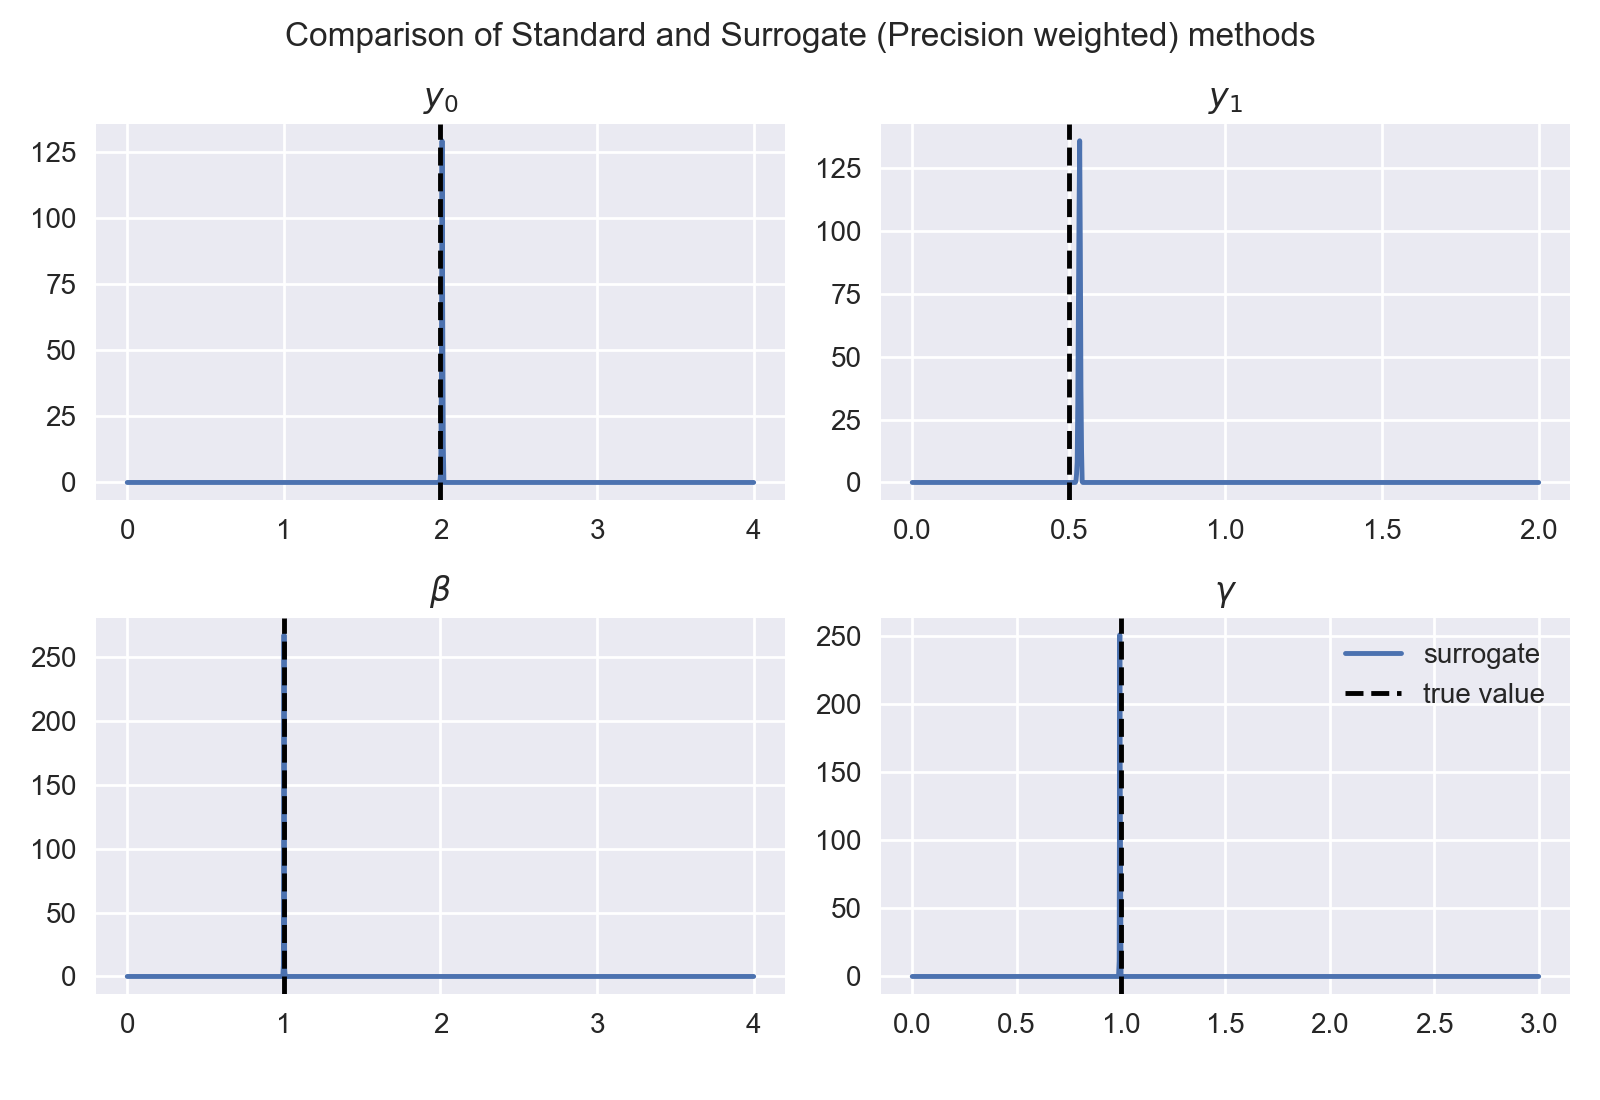

In [32]:
fig = plt.figure()
# y_o
plt.subplot(221)
x = np.linspace(0,4,1000)
# plt.plot(x,kdes_std[0].pdf(x),label='standard')
plt.plot(x,kdes_sur[0].pdf(x),label='surrogate')
plt.axvline(2,ls='--',c='k')
plt.title("$y_0$")

# y_1
plt.subplot(222)
x = np.linspace(0,2,1000)
# plt.plot(x,kdes_std[1].pdf(x),label='standard')
plt.plot(x,kdes_sur[1].pdf(x),label='surrogate')
plt.axvline(.5,ls='--',c='k')
plt.title("$y_1$")

# beta
plt.subplot(223)
x = np.linspace(0,4,1000)
# plt.plot(x,kdes_std[2].pdf(x),label='standard')
plt.plot(x,kdes_sur[2].pdf(x),label='surrogate')
plt.axvline(1,ls='--',c='k')
plt.title("$\\beta$")

# gamma
plt.subplot(224)
x = np.linspace(0,3,1000)
# plt.plot(x,kdes_std[3].pdf(x),label='standard')
plt.plot(x,kdes_sur[3].pdf(x),label='surrogate')
plt.axvline(1,ls='--',c='k',label='true value')
plt.title("$\\gamma$")


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Comparison of Standard and Surrogate (Precision weighted) methods")
plt.legend()
# plt.savefig('figures/sur1_kdes.pdf')
plt.show()

In [33]:
y_noisy

array([[2.02977218, 0.99350953, 0.46351541, 0.28855728, 0.42494348,
        1.56646565, 2.1801117 , 1.1079175 , 0.51902165, 0.31951711],
       [0.50248414, 0.28268093, 0.43186564, 0.85787259, 1.774839  ,
        2.1697727 , 0.56175893, 0.29433524, 0.36147151, 0.76949221]])

In [37]:
type([]) == list

True

# Shared Covariance vs Separate

In [47]:
y_hr = solve_lv(T_sur,y0,a,b,c,d)

In [50]:
rv = stats.multivariate_normal(mean=mean1,cov=cov1_gp)

In [52]:
%timeit rv.logpdf(y_hr)

38.2 µs ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [53]:
%timeit stats.multivariate_normal.logpdf(y_hr,mean=mean1,cov=cov1_gp)

5.02 ms ± 594 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [58]:
%timeit la.norm(W1@(y_hr[0]-mean1))**2

49.1 µs ± 2.29 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [56]:
%timeit []

23 ns ± 4.75 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)
